{1: [15, 28], 2: [9, 20], 3: [75, 22], 4: [71, 34], 5: [40, 26]}


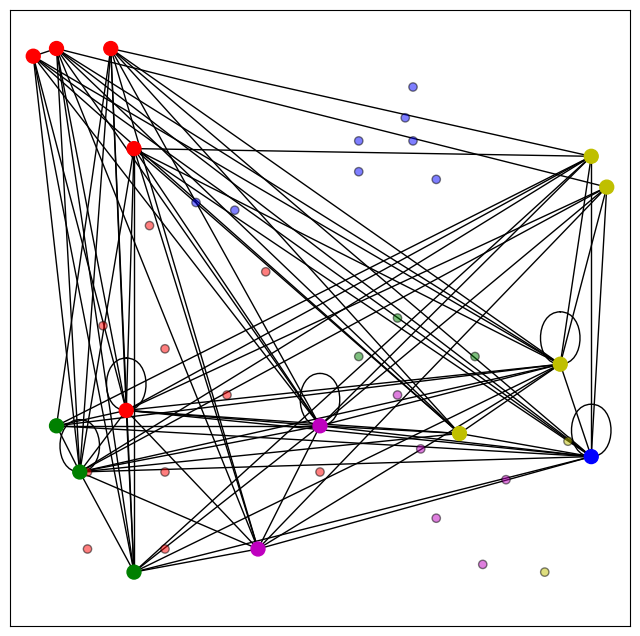

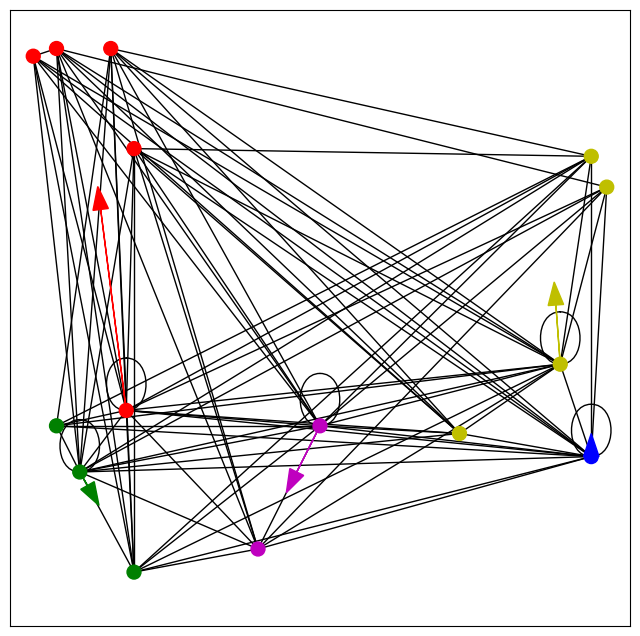

In [207]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import copy

# Creazione del grafo
G = nx.gnm_random_graph(n=10, m=20, seed=42)

# Centroidi
np.random.seed(20)
k = 5
centroids = {
    i+1: [np.random.randint(0, 80), np.random.randint(0, 80)]
    for i in range(k)
}

# Definizione del dizionario "colmap"
colmap = {1: 'r', 2: 'g', 3: 'b', 4: 'y', 5: 'm'}

# Lista dei nodi dei centroidi
centroid_nodes_list = []

# Aggiungi i punti dati come nodi al grafo con la chiave 'closest' e 'color'
for node in G.nodes():
    G.nodes[node]['pos'] = (np.random.randint(0, 80), np.random.randint(0, 80))
    G.nodes[node]['color'] = 'b'
    G.nodes[node]['closest'] = None

# Aggiungi i centroidi come nodi al grafo e aggiungi i nodi alla lista dei centroidi
for i in centroids.keys():
    centroid_coords = centroids[i]
    centroid_node = f'Centroid_{i}'
    centroid_nodes_list.append(centroid_node)
    G.add_node(centroid_node, pos=centroid_coords, color=colmap[i], closest=None)

# Calcola le distanze tra punti e centroidi e crea gli archi del grafo
for node in G.nodes():
    for centroid in centroids.keys():
        centroid_coords = centroids[centroid]
        distance = np.sqrt((G.nodes[node]['pos'][0] - centroid_coords[0])**2 + (G.nodes[node]['pos'][1] - centroid_coords[1])**2)
        G.add_edge(node, f'Centroid_{centroid}', weight=distance)

# Funzione di assegnazione dei nodi ai centroidi più vicini
def assignment(G, centroids):
    for node in G.nodes():
        if not G.nodes[node]['closest'] or not G.nodes[node]['closest'].startswith('Centroid'):
            node_coords = G.nodes[node]['pos']
            distances = {
                centroid: np.sqrt((node_coords[0] - centroids[centroid][0])**2
                                  + (node_coords[1] - centroids[centroid][1])**2)
                for centroid in centroids.keys()
            }
            closest_centroid = min(distances, key=distances.get)
            G.nodes[node]['closest'] = closest_centroid
            G.nodes[node]['color'] = colmap[closest_centroid]

# Funzione di aggiornamento dei centroidi
def update(G, centroids):
    for centroid in centroids.keys():
        centroid_nodes = [node for node in G.nodes() if G.nodes[node]['closest'] == centroid]
        x_mean = np.mean([G.nodes[node]['pos'][0] for node in centroid_nodes])
        y_mean = np.mean([G.nodes[node]['pos'][1] for node in centroid_nodes])
        centroids[centroid] = [x_mean, y_mean]

# Assegnazione iniziale dei nodi ai centroidi più vicini
assignment(G, centroids)
print(centroids)

# Disegna il grafo iniziale
plt.figure(figsize=(8, 8))
pos = nx.get_node_attributes(G, 'pos')
colors = [node[1]['color'] for node in G.nodes(data=True)]
weights = nx.get_edge_attributes(G, 'weight').values()

nx.draw_networkx(G, pos, node_color=colors, with_labels=False, node_size=100)
nx.draw_networkx_edges(G, pos, width=list(weights), alpha=0)

plt.xlim(0, 80)
plt.ylim(0, 80)
plt.show()

# Aggiorna i centroidi e mostra le frecce che rappresentano gli spostamenti
old_centroids = copy.deepcopy(centroids)
update(G, centroids)

# Disegna il grafo con gli spostamenti dei centroidi
plt.figure(figsize=(8, 8))
pos = nx.get_node_attributes(G, 'pos')
colors = [node[1]['color'] for node in G.nodes(data=True)]
weights = nx.get_edge_attributes(G, 'weight').values()

nx.draw_networkx(G, pos, node_color=colors, with_labels=False, node_size=100)
nx.draw_networkx_edges(G, pos, width=list(weights), alpha=0)
plt.xlim(0, 80)
plt.ylim(0, 80)

plt.title('Iterazione 1')

for centroid in old_centroids.keys():
    old_x = old_centroids[centroid][0]
    old_y = old_centroids[centroid][1]
    dx = (centroids[centroid][0] - old_centroids[centroid][0]) * 0.75
    dy = (centroids[centroid][1] - old_centroids[centroid][1]) * 0.75
    plt.arrow(old_x, old_y, dx, dy, head_width=2, head_length=3, fc=colmap[centroid], ec=colmap[centroid])

plt.show()
